In [1]:
from ingest import DataFrame

In [2]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from pickle import load

#### Preprocess
Food.com dataset CSV available [on Kaggle](https://www.kaggle.com/datasets/realalexanderwei/food-com-recipes-with-ingredients-and-tags)

Read in the same processed ingredients data as in 

    1_rbm_train.py.

Instead of fitting a word-vector Binarizer and RBM, load these from pickle.


In [4]:

PATH = "/home/jovyan/d/datasets/foodcom_2023/share/recipes_ingredients.csv"

df = DataFrame(PATH)

  0%|          | 0/500471 [00:00<?, ?it/s]

  0%|          | 0/423341 [00:00<?, ?it/s]

In [5]:
df = df.df.sample(80*10**3)

#### Load

Binarizer and RBM loaded from pickle.

In [6]:
# RBM, multi-label-binarizer
rbm, mlb = load(open("./out/rbm_dec22.pkl", 'rb')),\
load(open("./out/mlb_dec22.pkl", 'rb'))

In [7]:
# To give an idea for size of vector embeddings
len(mlb.classes_)

4632

Apply TSNE for dimensionality reduction of hidden units (word embeddings).  Direct TSNE (d-to-2 dimensions) and 2-step (d-to-3-to-2 dimensions) TSNE are provided

In [8]:
def attempt():
    # Direct d-to-2 (requires initialization of many clusters to break
    # apart embeddings mass in d-dim space)
    flattened_ingreds = []

    for u in df.dropna().sample(200).sampled_words.iloc[:200].to_list():
        flattened_ingreds += u

    # Init 128 clusters
    kmeans = KMeans(n_clusters=128, max_iter=24000)

    rbm_embeds = rbm.str_sample_hidden([[u] for u in flattened_ingreds], mlb)

    yostacity = kmeans.fit_predict(rbm_embeds)
    tsne = TSNE(n_iter=2500)
    embeds = tsne.fit_transform(rbm.str_sample_hidden(
        [[u] for u in flattened_ingreds], mlb))
    ingred_labels = [u for u in flattened_ingreds]
    one_label_df = pd.DataFrame({
        'x': embeds[:,0],
        'y': embeds[:,1],
        'c': yostacity,
        'label': ingred_labels}).groupby('label').agg(lambda x: list(x)[0])

    one_label_df = one_label_df.sample(200)
    fig, ax = plt.subplots(figsize=(12,12))
    # ax.scatter(embeds[:,0], embeds[:,1])
    ax.scatter(one_label_df.x, one_label_df.y, c=one_label_df.c)
    for i, txt in enumerate(one_label_df.index):
        ax.annotate(txt, (one_label_df.x.iloc[i], one_label_df.y.iloc[i]))

In [9]:
def attempt_reduce_sequential_barnes():
    # Two step d-to-3-to-2
    flattened_ingreds = []

    for u in df.dropna().sample(200).sampled_words.iloc[:200].to_list():
        flattened_ingreds += u

    # Init 12 clusters
    kmeans = KMeans(n_clusters=12, max_iter=24000)

    rbm_embeds = rbm.str_sample_hidden([[u] for u in flattened_ingreds], mlb)

    tsne_1 = TSNE(n_iter=2500,n_components=3)
    rbm_embeds_1 = tsne_1.fit_transform(rbm_embeds)

    # rbm_embeds
    yostacity = kmeans.fit_predict(rbm_embeds_1)
    tsne = TSNE(n_iter=2500)
    embeds = tsne.fit_transform(rbm_embeds_1)
    ingred_labels = [u for u in flattened_ingreds]
    one_label_df = pd.DataFrame({
        'x': embeds[:,0],
        'y': embeds[:,1],
        'c': yostacity,
        'label': ingred_labels}).groupby('label').agg(lambda x: list(x)[0])

    one_label_df = one_label_df.sample(200)
    fig, ax = plt.subplots(figsize=(12,12))
    # ax.scatter(embeds[:,0], embeds[:,1])
    ax.scatter(one_label_df.x, one_label_df.y, c=one_label_df.c)
    for i, txt in enumerate(one_label_df.index):
        ax.annotate(txt, (one_label_df.x.iloc[i], one_label_df.y.iloc[i]))

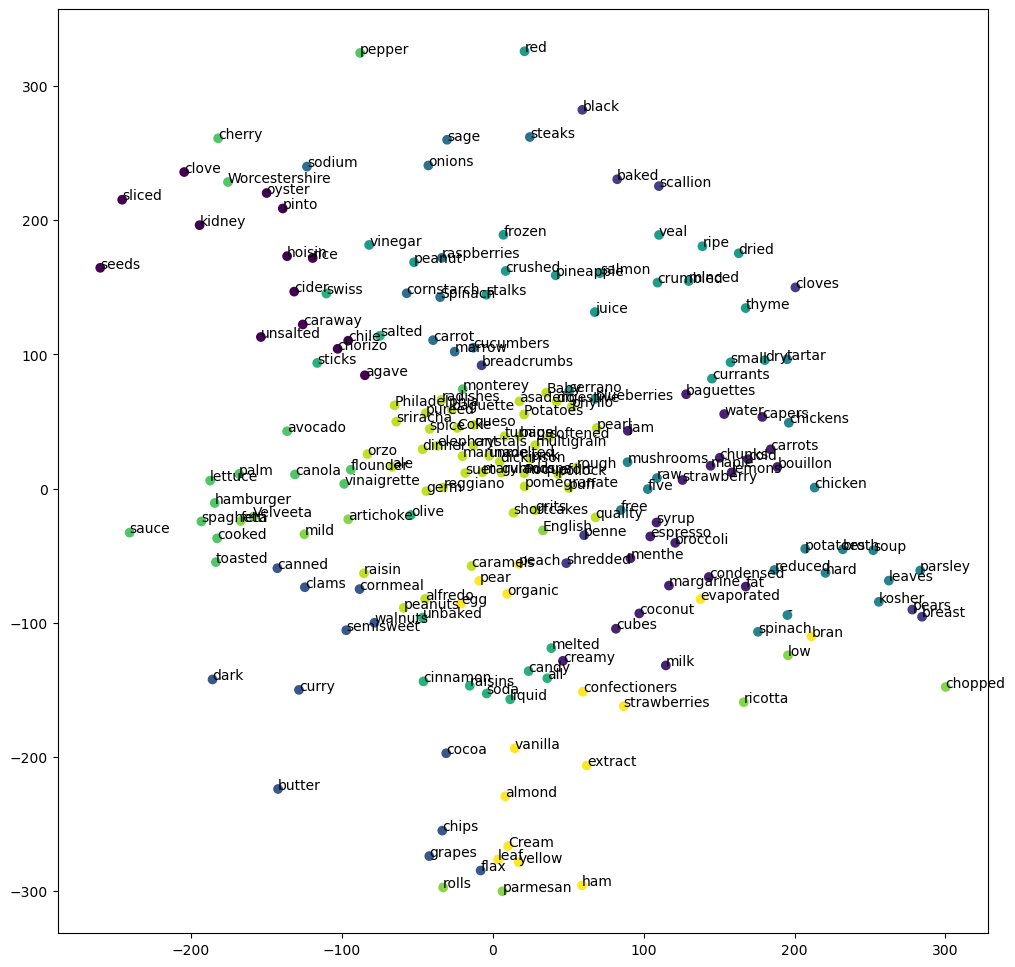

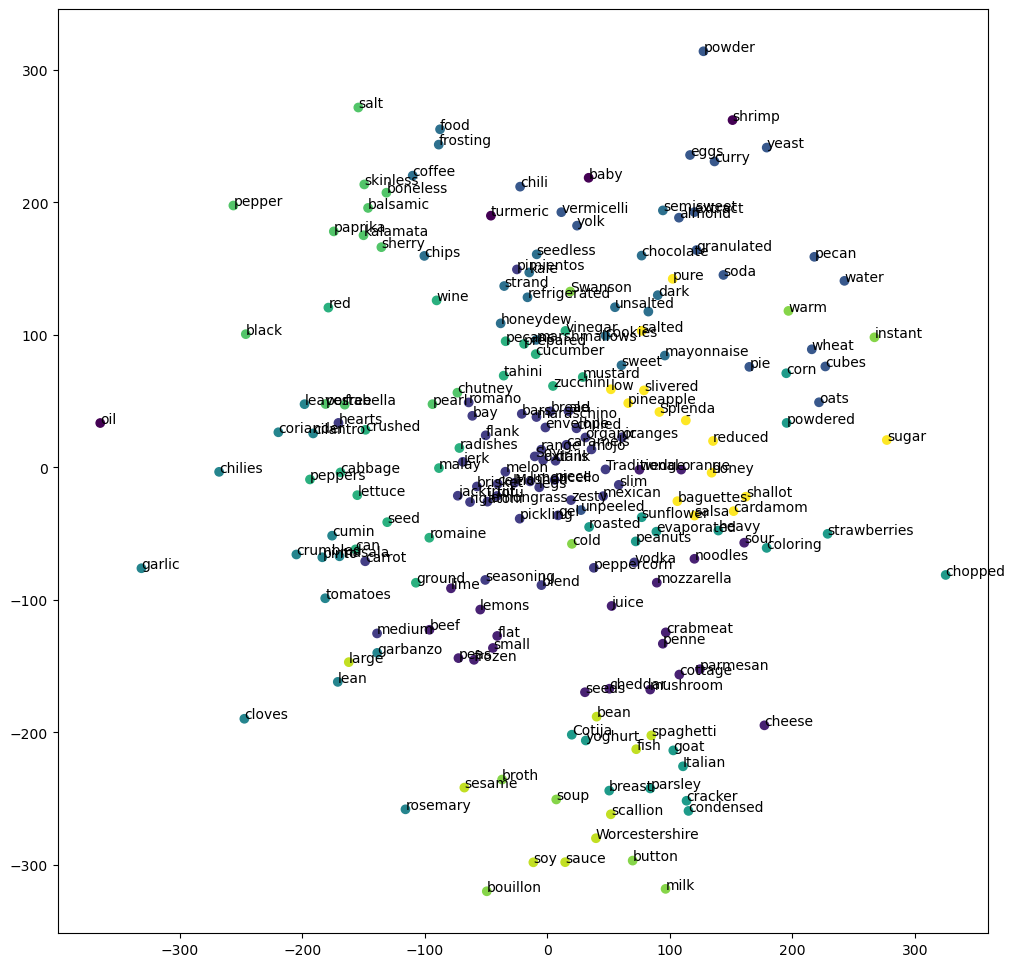

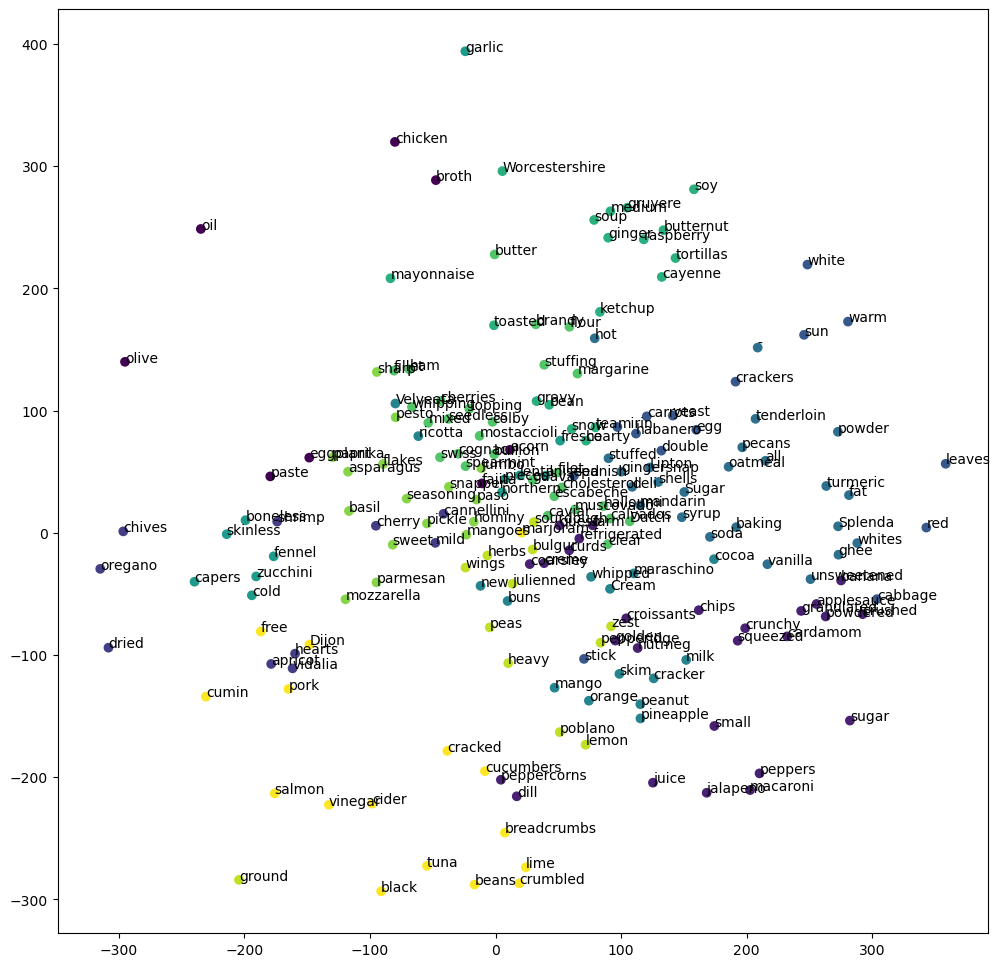

In [10]:
for i in range(3):
    # Two step (K-means does better in 3-dim than large d-dim)
    attempt_reduce_sequential_barnes()
    plt.show()

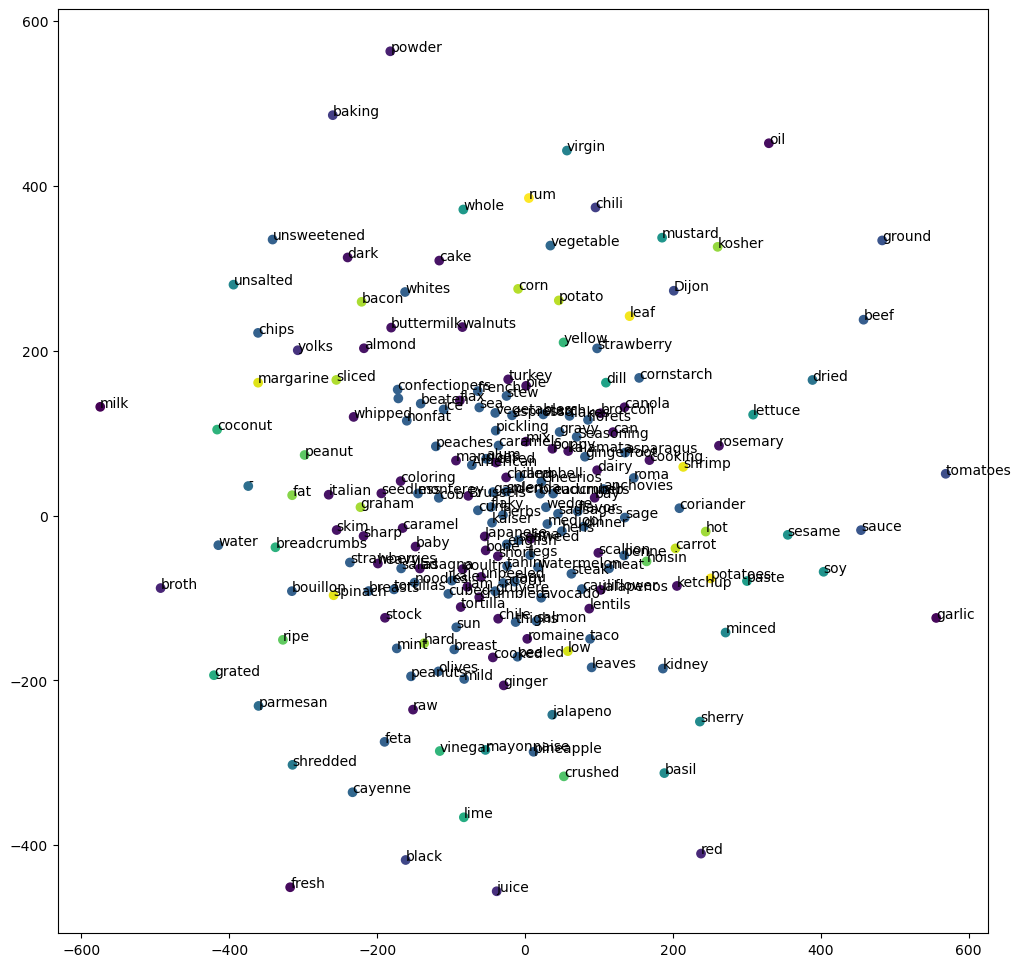

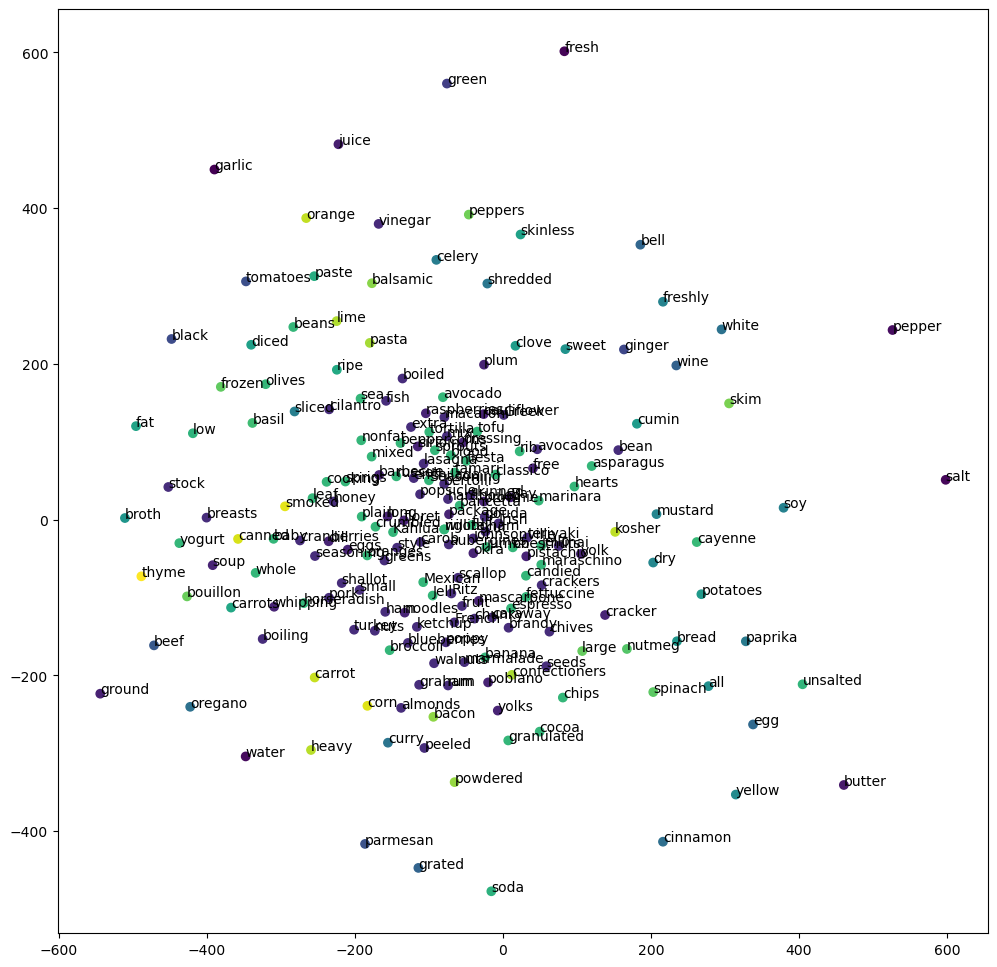

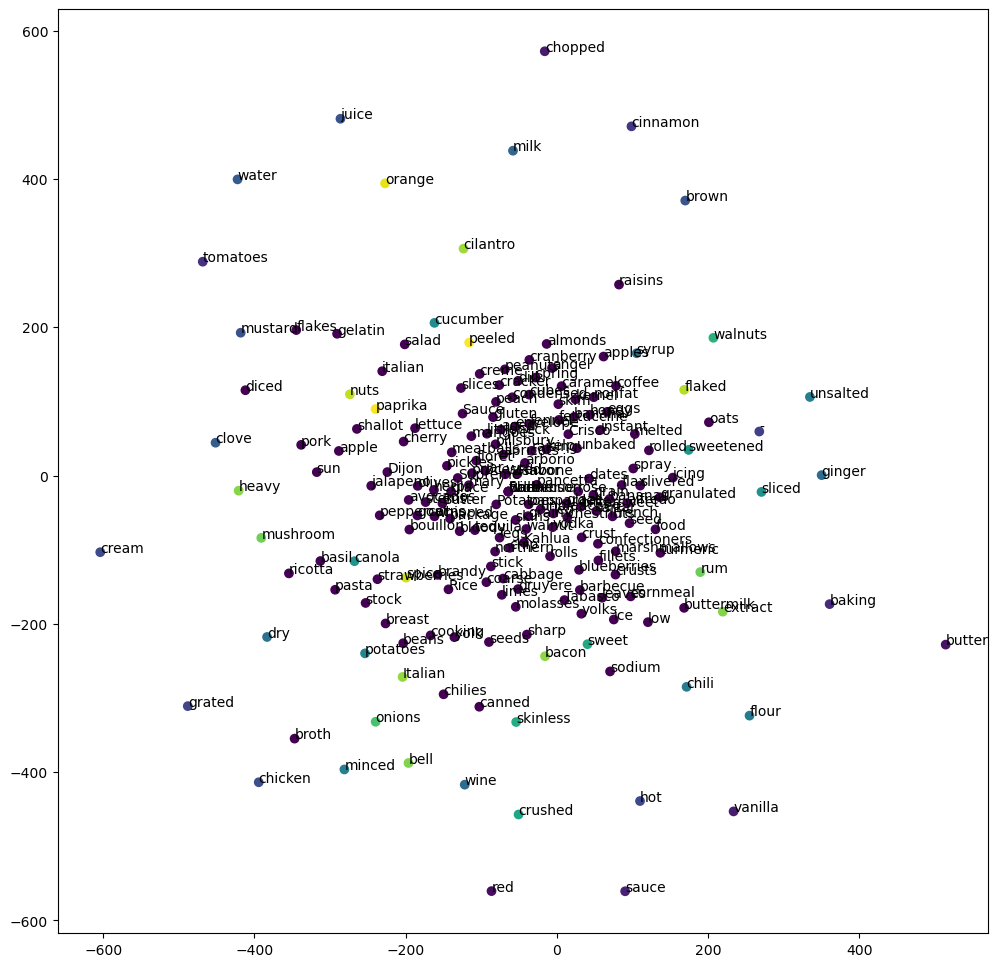

In [11]:
for i in range(3):
    attempt()
    plt.show()